In [1]:
# Cell 0
# Install libraries
# - transformers/datasets accelerate => for BERT + Trainer API (Hugging Face)
# - scikit-learn => for Logistic Regression baseline
# - matplotlib/seaborn => for plots
!pip -q install transformers datasets accelerate torch --upgrade
!pip -q install scikit-learn matplotlib seaborn tqdm



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [11]:
# Cell 1
# Imports and global config
import os, math, random, time
from dataclasses import dataclass
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, roc_curve, auc

import torch
from torch.utils.data import Dataset

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding
)

# Make plots look nice
sns.set(style="whitegrid")

# Reproducibility
RANDOM_SEED = 6905
def set_seed(seed=RANDOM_SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
set_seed(RANDOM_SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cpu


In [12]:
# Cell 2
# Loading the dataset

df = pd.read_csv("EduPilot_dataset_2000.csv")

# Sanity checks
print("Columns:", list(df.columns))
print("Rows:", len(df))
print(df.head(5))

# Required columns check (will raise if missing)
required = {"text", "interview_round"}
missing = required - set(df.columns)
assert not missing, f"Missing required columns: {missing}"
label_words = ["OA", "Technical", "System Design", "Behavioral/HR", "ML Case Study"]

# check for presence of label_words in "text"
def contains_label(text):
    for w in label_words:
        if w in str(text):
            return True
    return False

mask = df["text"].apply(contains_label)
df.loc[mask, ["id", "text", "interview_round"]].head(10)

Columns: ['id', 'user_query', 'job_role', 'company', 'location', 'interview_round', 'mock_question', 'text']
Rows: 2000
   id                                         user_query          job_role  \
0   1  What should I study for a Data Scientist posit...    Data Scientist   
1   2  I have an interview for SRE at Salesforce in L...               SRE   
2   3  I have an interview for Product Manager at Pin...   Product Manager   
3   4  Help me practice for Backend Engineer intervie...  Backend Engineer   
4   5  Give me common interview problems for Backend ...  Backend Engineer   

      company   location interview_round  \
0        Uber    Toronto              OA   
1  Salesforce     London              OA   
2   Pinterest    Seattle              OA   
3     Dropbox  Hyderabad              OA   
4       Apple     Munich              OA   

                                       mock_question  \
0    Count islands in a binary matrix using DFS/BFS.   
1  Given a string, return length o

,id,text,interview_round


In [13]:
# Using 'mock_question' resulted in 1.0 accuracy
# Building a leak-safe text field that excludes both label words and `mock_question`
label_words = ["OA", "Technical", "System Design", "Behavioral/HR", "ML Case Study"]

def strip_labels(text, labels):
    t = str(text)
    for w in labels:
        t = t.replace(w, "")
    return " ".join(t.split())

def make_text_safe(row):
    # DO NOT include mock_question here – it's round-specific
    parts = [
        strip_labels(row["user_query"], label_words),
        str(row["job_role"]),
        str(row["company"]),
        str(row["location"]),
    ]
    return " ||| ".join([p for p in parts if p])

df["text_safe"] = df.apply(make_text_safe, axis=1)

# Sanity: ensure no label words remain
assert not df["text_safe"].str.contains("|".join(label_words), case=False, na=False).any()

In [ ]:
# ============================================================
# TF-IDF  →  2-layer MLP (PyTorch)  →  MIA (threshold)
# ============================================================
import os, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, log_loss, roc_curve, auc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# -------------------------
# 0) Config
# -------------------------
RANDOM_SEED = 6905
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"

TEXT_COL = "text_safe" if "text_safe" in df.columns else "text"  # prefer leak-safe text
LABEL_COL = "interview_round"
TEST_SIZE = 0.30

# Vectorizer params (high capacity → mild overfitting → stronger MIA)
NGRAMS = (1,3)
MAX_FEATS = 40_000

# MLP params (intentionally a bit over-parameterized)
HID = 512
EPOCHS = 18
BATCH = 64
LR = 3e-4
WEIGHT_DECAY = 0.0  # keep 0 to allow some overfitting

# Optional LiRA (shadow models)
ENABLE_LIRA = False
SHADOWS = 64           # we can increase it to 128 or 256
SAMPLE_FRAC = 0.6      # <= 0.6 gives more diversity (helps LiRA)
SHADOW_EPOCHS = 8      # keeping it small so it finishes

# -------------------------
# 1) Split + labels
# -------------------------
train_df, test_df = train_test_split(
    df, test_size=TEST_SIZE, stratify=df[LABEL_COL], random_state=RANDOM_SEED
)

le = LabelEncoder()
y_train = le.fit_transform(train_df[LABEL_COL])
y_test  = le.transform(test_df[LABEL_COL])
num_labels = len(le.classes_)
print("Classes:", list(le.classes_))

# -------------------------
# 2) TF-IDF features
# -------------------------
tfidf = TfidfVectorizer(ngram_range=NGRAMS, max_features=MAX_FEATS)
X_train = tfidf.fit_transform(train_df[TEXT_COL])
X_test  = tfidf.transform(test_df[TEXT_COL])

# Helper dataset that reads from a CSR matrix without densifying the whole thing
class CSRDataset(Dataset):
    def __init__(self, X_csr, y):
        self.X = X_csr
        self.y = y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        # convert this row to a dense float32 vector on the fly
        x = torch.tensor(self.X[idx].toarray()[0], dtype=torch.float32)
        y = torch.tensor(int(self.y[idx]), dtype=torch.long)
        return x, y

train_ds = CSRDataset(X_train, y_train)
test_ds  = CSRDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, drop_last=False)

# -------------------------
# 3) Defineing 2-layer MLP
# -------------------------
class MLP(nn.Module):
    def __init__(self, in_dim, hid, out_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hid)
        self.fc2 = nn.Linear(hid, out_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)  # logits

mlp = MLP(in_dim=X_train.shape[1], hid=HID, out_dim=num_labels).to(device)
opt = torch.optim.Adam(mlp.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss()

# -------------------------
# 4) Train
# -------------------------
def run_epoch(loader, train=True):
    model = mlp
    if train: model.train()
    else:     model.eval()
    total_loss, total_correct, total_n = 0.0, 0, 0
    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                opt.zero_grad()
                loss.backward()
                opt.step()
            total_loss += float(loss.item()) * xb.size(0)
            total_correct += int((logits.argmax(-1) == yb).sum().item())
            total_n += xb.size(0)
    return total_loss/total_n, total_correct/total_n

print(f"Training on {len(train_ds)} samples; validating on {len(test_ds)} samples...")
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    te_loss, te_acc = run_epoch(test_loader,  train=False)
    if ep % 2 == 0 or ep == 1:
        print(f"Epoch {ep:02d}: train loss {tr_loss:.4f} acc {tr_acc:.3f} | test loss {te_loss:.4f} acc {te_acc:.3f}")

# -------------------------
# 5) Final evaluation + per-example losses
# -------------------------
@torch.no_grad()
def collect_losses(loader):
    model = mlp
    model.eval()
    losses, probs, labels = [], [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        lp = F.log_softmax(logits, dim=-1)
        chosen = lp[torch.arange(lp.size(0)), yb]  # log prob of the true class
        losses.extend((-chosen).cpu().numpy().tolist())
        probs.extend(torch.softmax(logits, dim=-1).cpu().numpy().tolist())
        labels.extend(yb.cpu().numpy().tolist())
    return np.array(losses), np.array(probs), np.array(labels)

train_losses_mlp, train_probs_mlp, train_y_true = collect_losses(train_loader)
test_losses_mlp,  test_probs_mlp,  test_y_true  = collect_losses(test_loader)

# Accuracy and log-loss on test
test_pred_mlp = test_probs_mlp.argmax(axis=1)
acc_mlp = accuracy_score(test_y_true, test_pred_mlp)
ll_mlp  = log_loss(test_y_true, test_probs_mlp)
print(f"\nMLP — Test accuracy: {acc_mlp:.4f}")
print(f"MLP — Test log-loss : {ll_mlp:.4f}")
print(f"Mean losses — train: {train_losses_mlp.mean():.4f} | test: {test_losses_mlp.mean():.4f}")

Epoch 01: train acc 0.891 | test acc 0.200
Epoch 02: train acc 0.898 | test acc 0.200
Epoch 04: train acc 0.915 | test acc 0.205
Epoch 06: train acc 0.931 | test acc 0.202
Epoch 08: train acc 0.937 | test acc 0.197
Epoch 10: train acc 0.946 | test acc 0.202
Epoch 12: train acc 0.950 | test acc 0.200
Epoch 14: train acc 0.960 | test acc 0.197
Epoch 16: train acc 0.960 | test acc 0.195
Epoch 18: train acc 0.962 | test acc 0.190


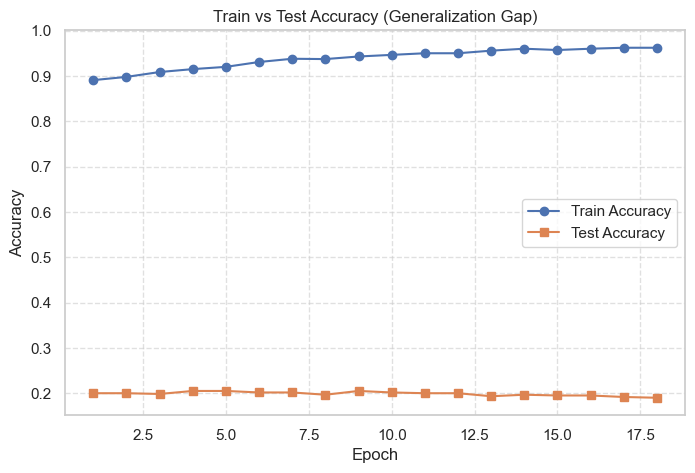

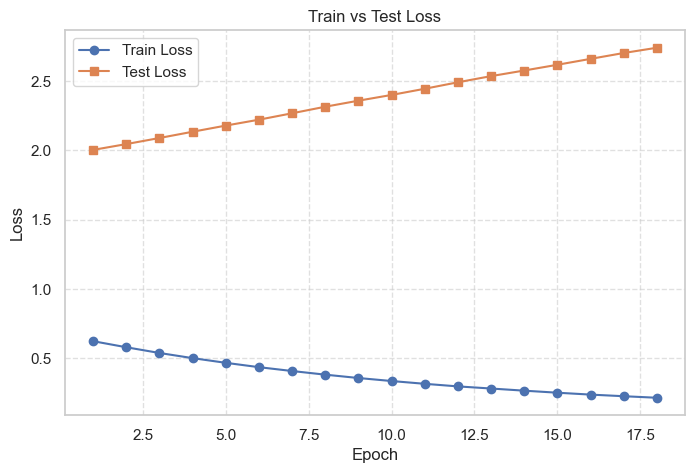

In [15]:
import matplotlib.pyplot as plt

# Track train/test metrics during training
train_acc_hist, test_acc_hist = [], []
train_loss_hist, test_loss_hist = [], []

def run_epoch(loader, train=True):
    model = mlp
    if train: model.train()
    else:     model.eval()
    total_loss, total_correct, total_n = 0.0, 0, 0
    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                opt.zero_grad()
                loss.backward()
                opt.step()
            total_loss += float(loss.item()) * xb.size(0)
            total_correct += int((logits.argmax(-1) == yb).sum().item())
            total_n += xb.size(0)
    return total_loss/total_n, total_correct/total_n

# Training with history logging
EPOCHS = 18
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    te_loss, te_acc = run_epoch(test_loader, train=False)

    train_loss_hist.append(tr_loss)
    train_acc_hist.append(tr_acc)
    test_loss_hist.append(te_loss)
    test_acc_hist.append(te_acc)

    if ep % 2 == 0 or ep == 1:
        print(f"Epoch {ep:02d}: train acc {tr_acc:.3f} | test acc {te_acc:.3f}")

# --- Plot accuracy gap ---
plt.figure(figsize=(8,5))
plt.plot(range(1, EPOCHS+1), train_acc_hist, label="Train Accuracy", marker="o")
plt.plot(range(1, EPOCHS+1), test_acc_hist, label="Test Accuracy", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy (Generalization Gap)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# --- Plot loss gap ---
plt.figure(figsize=(8,5))
plt.plot(range(1, EPOCHS+1), train_loss_hist, label="Train Loss", marker="o")
plt.plot(range(1, EPOCHS+1), test_loss_hist, label="Test Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


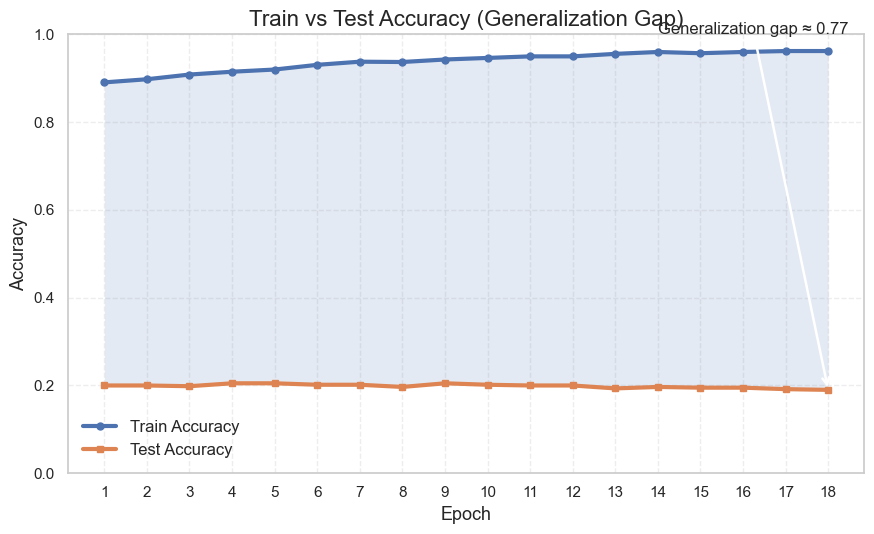

In [16]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, len(train_acc_hist)+1)

plt.figure(figsize=(9,5.5))
plt.plot(epochs, train_acc_hist, linewidth=3, marker="o", markersize=5, label="Train Accuracy")
plt.plot(epochs, test_acc_hist,  linewidth=3, marker="s", markersize=5, label="Test Accuracy")

# shaded gap
upper = np.maximum(train_acc_hist, test_acc_hist)
lower = np.minimum(train_acc_hist, test_acc_hist)
plt.fill_between(epochs, lower, upper, alpha=0.15)

# annotate last-epoch gap
gap = train_acc_hist[-1] - test_acc_hist[-1]
plt.annotate(f"Generalization gap ≈ {gap:.2f}",
             xy=(epochs[-1], test_acc_hist[-1]),
             xytext=(epochs[-1]-4, min(1.0, train_acc_hist[-1]+0.05)),
             arrowprops=dict(arrowstyle="->", lw=1.8), fontsize=12)

plt.title("Train vs Test Accuracy (Generalization Gap)", fontsize=16)
plt.xlabel("Epoch", fontsize=13); plt.ylabel("Accuracy", fontsize=13)
plt.xticks(epochs)
plt.ylim(0, 1.0)
plt.grid(True, linestyle="--", alpha=0.35)
plt.legend(frameon=False, fontsize=12)
plt.tight_layout()
plt.savefig("gap_accuracy.png", dpi=200, bbox_inches="tight", transparent=True)
plt.show()


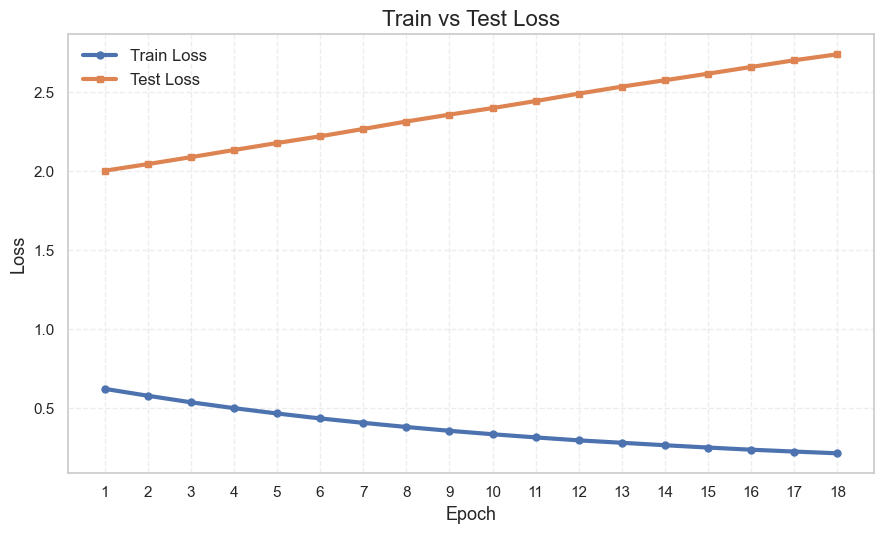

In [17]:
plt.figure(figsize=(9,5.5))
plt.plot(epochs, train_loss_hist, linewidth=3, marker="o", markersize=5, label="Train Loss")
plt.plot(epochs, test_loss_hist,  linewidth=3, marker="s", markersize=5, label="Test Loss")

plt.title("Train vs Test Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=13); plt.ylabel("Loss", fontsize=13)
plt.xticks(epochs)
plt.grid(True, linestyle="--", alpha=0.35)
plt.legend(frameon=False, fontsize=12)
plt.tight_layout()
plt.savefig("gap_loss.png", dpi=200, bbox_inches="tight", transparent=True)
plt.show()


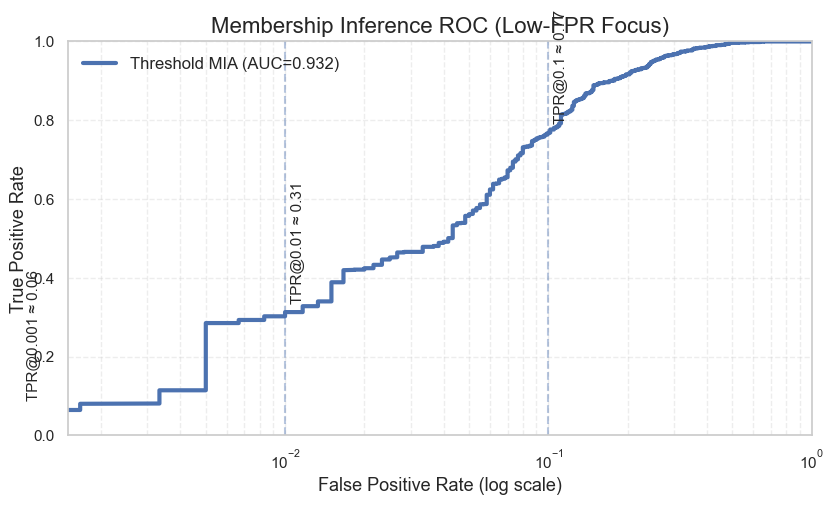

In [20]:
plt.figure(figsize=(8.5,5.2))
plt.plot(fpr_mia, tpr_mia, linewidth=3, label=f"Threshold MIA (AUC={auc_mia:.3f})")

# vertical markers at the LiRA-relevant low-FPR regimes
for x in [1e-1, 1e-2, 1e-3]:
    plt.axvline(x, linestyle="--", alpha=0.4)
    tpr_val = tpr_at_fpr(fpr_mia, tpr_mia, x)
    plt.text(x*1.05, min(0.98, tpr_val+0.03), f"TPR@{x:g} ≈ {tpr_val:.2f}", rotation=90, fontsize=11)

plt.xscale("log")
plt.xlim(min(fpr_mia[fpr_mia>0])*0.9, 1.0)
plt.ylim(0.0, 1.0)
plt.title("Membership Inference ROC (Low-FPR Focus)", fontsize=16)
plt.xlabel("False Positive Rate (log scale)", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.grid(True, which="both", linestyle="--", alpha=0.35)
plt.legend(frameon=False, fontsize=12)
plt.tight_layout()
plt.savefig("roc_low_fpr.png", dpi=220, bbox_inches="tight", transparent=True)
plt.show()


[LiRA] example 0 has 152 IN obs and 104 OUT obs (should be >=1 each).


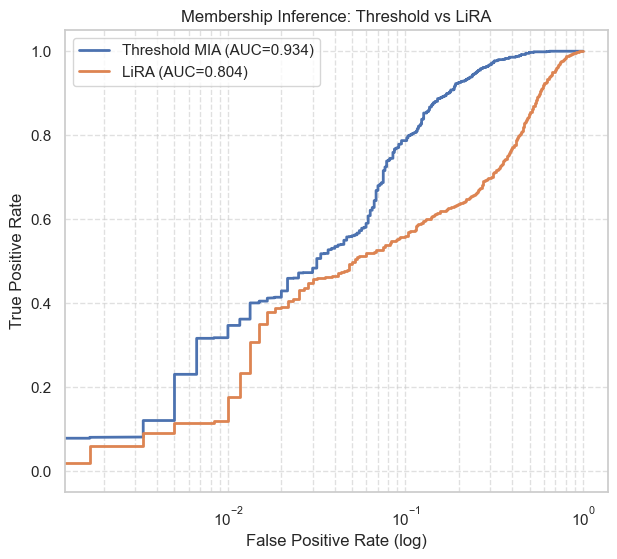

Threshold MIA  TPR@FPR<=0.100: 0.7871
LiRA           TPR@FPR<=0.100: 0.5593
Threshold MIA  TPR@FPR<=0.010: 0.3471
LiRA           TPR@FPR<=0.010: 0.1771
Threshold MIA  TPR@FPR<=0.001: 0.0786
LiRA           TPR@FPR<=0.001: 0.0200


In [24]:
# Both MIA and LiRA on MLP in one place

# ============================================================
# LiRA (Likelihood Ratio Attack) on top of TF-IDF + 2-layer MLP
# I am training one TARGET model (the real classifier),
# then many small SHADOW models to learn loss distributions
# for each example when it is "IN" train vs "OUT" of train.
# Later I compute a LiRA score and compare with simple Threshold MIA.
# ============================================================

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc, accuracy_score, log_loss

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# -------------------------
# 0) Config
# -------------------------
RANDOM_SEED   = 6905
TEST_SIZE     = 0.30
NGRAMS        = (1, 3)
MAX_FEATS     = 40_000

# classifier hyperparams (a little over-sized so it can overfit bit)
HID           = 512
EPOCHS        = 18
BATCH         = 64
LR            = 3e-4
WEIGHT_DECAY  = 0.0

# LiRA shadows
SHADOWS        = 256
SHADOW_EPOCHS  = 6           # short training so shadows finish fast
SAMPLE_FRAC    = 0.6         # each shadow train uses 60% of target examples

device = "cuda" if torch.cuda.is_available() else "cpu"
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Using the "text_safe" column
LABEL_COL = "interview_round"
TEXT_COL  = "text_safe"

# -------------------------
# 1) Vectorize once over full data (so shadows share same vocab)
# -------------------------
le = LabelEncoder()
y_all = le.fit_transform(df[LABEL_COL])

tfidf = TfidfVectorizer(ngram_range=NGRAMS, max_features=MAX_FEATS)
X_all = tfidf.fit_transform(df[TEXT_COL])

# target split: these are the examples I will call "members" (train) vs "non-members" (test)
train_idx, test_idx = train_test_split(
    np.arange(len(df)), test_size=TEST_SIZE, stratify=y_all, random_state=RANDOM_SEED
)

# -------------------------
# 2) Torch helpers (dataset + 2-layer MLP + small training loop)
# -------------------------
class CSRDataset(Dataset):
    def __init__(self, X_csr, y):
        self.X = X_csr; self.y = y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        # turn 1 sparse row into dense float vector (PyTorch want tensors)
        x = torch.tensor(self.X[idx].toarray()[0], dtype=torch.float32)
        y = torch.tensor(int(self.y[idx]), dtype=torch.long)
        return x, y

class MLP(nn.Module):
    def __init__(self, in_dim, hid, out_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hid)
        self.fc2 = nn.Linear(hid, out_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)  # logits (not softmax yet)

def train_simple_mlp(X_tr, y_tr, X_va, y_va, epochs=EPOCHS, lr=LR, wd=WEIGHT_DECAY, batch=BATCH):
    # I make one small helper that train a model and return it
    model = MLP(X_tr.shape[1], HID, len(np.unique(y_tr))).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    crit = nn.CrossEntropyLoss()
    tr_loader = DataLoader(CSRDataset(X_tr, y_tr), batch_size=batch, shuffle=True)
    va_loader = DataLoader(CSRDataset(X_va, y_va), batch_size=batch, shuffle=False)

    def _run(loader, train=True):
        if train: model.train()
        else:     model.eval()
        loss_sum, n = 0.0, 0
        with torch.set_grad_enabled(train):
            for xb, yb in loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = crit(logits, yb)
                if train:
                    opt.zero_grad(); loss.backward(); opt.step()
                loss_sum += float(loss.item()) * xb.size(0)
                n += xb.size(0)
        return loss_sum / n

    # I dont print every epoch here to keep it short. You can add prints if want.
    for _ in range(epochs):
        _run(tr_loader, train=True)
        _run(va_loader, train=False)
    return model

@torch.no_grad()
def per_example_losses(model, X_csr, y):
    # compute negative log-prob of the true class for each sample (this is "loss" per example)
    loader = DataLoader(CSRDataset(X_csr, y), batch_size=128, shuffle=False)
    losses = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        lp = F.log_softmax(logits, dim=-1)
        chosen = lp[torch.arange(lp.size(0)), yb]   # log p(true class)
        losses.extend((-chosen).cpu().numpy().tolist())
    return np.array(losses)

# -------------------------
# 3) Train the TARGET model (this is the real classifier we attack)
# -------------------------
X_train, y_train = X_all[train_idx], y_all[train_idx]
X_test,  y_test  = X_all[test_idx],  y_all[test_idx]

target = train_simple_mlp(X_train, y_train, X_test, y_test, epochs=EPOCHS)

# collect losses on train and test under the target model
loss_train_target = per_example_losses(target, X_train, y_train)  # members
loss_test_target  = per_example_losses(target,  X_test,  y_test)  # non-members

# -------------------------
# 4) Baseline Threshold MIA (simple, just use -loss)
# -------------------------
mia_scores = np.concatenate([-loss_train_target, -loss_test_target])   # higher = more "member like"
mia_labels = np.concatenate([np.ones_like(loss_train_target), np.zeros_like(loss_test_target)])
fpr_mia, tpr_mia, _ = roc_curve(mia_labels, mia_scores)
auc_mia = auc(fpr_mia, tpr_mia)

# -------------------------
# 5) LiRA shadows: I will train many small models on random "in/out" splits
# For each shadow, if example j was IN its train, its loss goes into IN[j], else OUT[j].
# Later I fit Gaussian to both lists and score the target's loss with log-likelihood ratio.
# -------------------------
all_idx   = np.concatenate([train_idx, test_idx])  # same order I will use for final labels
X_targetE = X_all[all_idx]
y_targetE = y_all[all_idx]

# per-example buckets
in_losses  = [[] for _ in range(len(all_idx))]
out_losses = [[] for _ in range(len(all_idx))]

# I use stratified splits so label balance stays nice in shadows
sss = StratifiedShuffleSplit(n_splits=SHADOWS, train_size=SAMPLE_FRAC, random_state=RANDOM_SEED)
for s_id, (rel_tr, rel_te) in enumerate(sss.split(all_idx, y_targetE), start=1):
    # shadow train/valid on relative indices (pointing into all_idx)
    Xs_tr, ys_tr = X_targetE[rel_tr], y_targetE[rel_tr]
    Xs_va, ys_va = X_targetE[rel_te], y_targetE[rel_te]

    # quick train of the shadow model (few epochs only)
    shadow = train_simple_mlp(Xs_tr, ys_tr, Xs_va, ys_va, epochs=SHADOW_EPOCHS)

    # now I compute loss for ALL target examples under this shadow
    losses_all = per_example_losses(shadow, X_targetE, y_targetE)

    # mark which examples were "IN" for this shadow
    in_mask = np.zeros(len(all_idx), dtype=bool)
    in_mask[rel_tr] = True

    # put loss to correct bucket
    for j in range(len(all_idx)):
        if in_mask[j]:
            in_losses[j].append(losses_all[j])
        else:
            out_losses[j].append(losses_all[j])

print("[LiRA] example 0 has", len(in_losses[0]), "IN obs and", len(out_losses[0]), "OUT obs (should be >=1 each).")

# -------------------------
# 6) Compute LiRA score per example
# score_j = log p(loss_target_j | IN) - log p(loss_target_j | OUT), Gaussian pdf
# higher score => looks more like a "member".
# -------------------------
from math import log, pi
def log_pdf_gaussian(x, mu, var):
    var = max(var, 1e-6)  # variance cant be 0 (numerical explode)
    return -0.5*(log(2*pi*var) + (x - mu)**2 / var)

# align target losses to same order as all_idx
loss_target_all = np.concatenate([loss_train_target, loss_test_target])

lira_scores = np.zeros(len(all_idx), dtype=float)
for j in range(len(all_idx)):
    Li = np.array(in_losses[j],  dtype=float)
    Lo = np.array(out_losses[j], dtype=float)
    # fit simple Gaussian to both lists (per-example modeling, this is the key LiRA idea)
    mu_in,  var_in  = Li.mean(), Li.var(ddof=1) if Li.size > 1 else 1e-6
    mu_out, var_out = Lo.mean(), Lo.var(ddof=1) if Lo.size > 1 else 1e-6
    lt = loss_target_all[j]  # the target model's loss for this example
    lira_scores[j] = log_pdf_gaussian(lt, mu_in, var_in) - log_pdf_gaussian(lt, mu_out, var_out)

# ground-truth membership for all_idx (first block are the original train members)
is_member_all = np.zeros(len(all_idx), dtype=int)
is_member_all[:len(train_idx)] = 1

fpr_lira, tpr_lira, _ = roc_curve(is_member_all, lira_scores)
auc_lira = auc(fpr_lira, tpr_lira)

# -------------------------
# 7) Plot: Threshold MIA vs LiRA (LiRA should be better at low FPR)
# -------------------------
plt.figure(figsize=(7,6))
plt.plot(fpr_mia,  tpr_mia,  label=f"Threshold MIA (AUC={auc_mia:.3f})", lw=2)
plt.plot(fpr_lira, tpr_lira, label=f"LiRA (AUC={auc_lira:.3f})", lw=2)
plt.xscale("log")
plt.xlabel("False Positive Rate (log)")
plt.ylabel("True Positive Rate")
plt.title("Membership Inference: Threshold vs LiRA")
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend()
plt.show()

# print TPR at strict low FPR, which is the important part from the paper
def tpr_at_fpr(fpr, tpr, target):
    idx = np.where(fpr <= target)[0]
    return float(tpr[idx].max()) if idx.size > 0 else 0.0

for target in [0.1, 0.01, 0.001]:
    print(f"Threshold MIA  TPR@FPR<={target:.3f}: {tpr_at_fpr(fpr_mia,  tpr_mia,  target):.4f}")
    print(f"LiRA           TPR@FPR<={target:.3f}: {tpr_at_fpr(fpr_lira, tpr_lira, target):.4f}")

# Note:
# This cell will take about 30mins to run on cpu!